In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory of `maps` (which is `src`)
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add `src` to the module search path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import pandas as pd
import numpy as np
import folium.features
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from pyproj import Transformer
import seaborn as sns
import networkx as nx
from scipy.spatial import Delaunay
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pyproj


from python_scripts.road_detection.road_utils import *
from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.graphs.graphs_creation import delaunay_graph
from python_scripts.city.city_utils import plotMapWithColors, mean_distance_choice, mean_distance_to_NN
from python_scripts.ihm.maps.mapUtils import *
from python_scripts.neighbours_criteria.enhanced_criteria import km_distance
from python_scripts.neighbours_criteria.simple_criteria import distance_criterion, angle_criterion


In [3]:
df = pd.read_csv("../../database/data.csv", sep=";", decimal=',')

In [4]:
df_extracted = extract_data(df, provider='Orange')#, techno='4g')#, region='Normandie') #Occitanie, Île-de-France
# G, pos = delaunay_graph(df_extracted)

In [5]:
cityLabels = pd.Series(DBSCAN(eps=1000, min_samples=11).fit(df_extracted[['x','y']]).labels_, index = df_extracted.index)
cityLabels = cityLabels.drop(cityLabels.loc[cityLabels==-1].index)
clusters = cityLabels.unique()
num_clusters = len(clusters)

In [6]:
cityBsStationCount = cityLabels.value_counts()

In [7]:
def getCityCenters(df_extracted, clusters, cityBsStationCount):
    res = {cityLabel : (0,0) for cityLabel in clusters}
    for bs_id, x, y in df_extracted[['x', 'y']].loc[cityLabels.index].itertuples():
        coords = res.get(cityLabels[bs_id])
        res[cityLabels[bs_id]] = (x + coords[0], y + coords[1])

    for cluster in clusters:
        res[cluster] = res.get(cluster) / cityBsStationCount[cluster]
    return res

In [8]:
# cityCenters = getCityCenters(df_extracted, clusters, cityStationsLabels, cityBsStationCount)

In [9]:
# array1 = np.array(list(cityCenters.values())).reshape(-1,2)
# array2 = np.array(df_extracted[['x', 'y']].values)

# # Initialize the NearestNeighbors model and fit it to list2
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(array2)

# # Find the nearest neighbors for each point in list1
# distances, indices = nbrs.kneighbors(array1)

# # Compute cities names
# cityNames = {cityId : df_extracted['nom_com'].loc[df_extracted.index[indice][0]] for (cityId, indice) in zip(cityCenters.keys(), indices)}
cityNames = {cityId : df_extracted['nom_com'].loc[cityLabels.loc[cityLabels==cityId].index].value_counts().index[0] for cityId in clusters}


# Merge clusters that have the same names
for cityName in np.sort(np.unique(list(cityNames.values()))):
    clustersWithSameName = [key for i, key in enumerate(list(cityNames.keys())) if list(cityNames.values())[i] == cityName]
    if(len(clustersWithSameName) > 1):
        clusterToKeep = np.min(clustersWithSameName)
        cityLabels = cityLabels.apply(lambda v: clusterToKeep if v in clustersWithSameName else v)
        for i in clustersWithSameName :
            if i != clusterToKeep:
                cityNames.pop(i)
clusters = list(cityLabels.unique())
num_clusters = len(clusters)
cityBsStationCount = cityLabels.value_counts()
cityCenters = getCityCenters(df_extracted, clusters, cityBsStationCount)

In [10]:
cities_infos = pd.read_csv("../../database/data_population.csv", sep=";", decimal=',')

populations = {}

for cluster in clusters:
    cityName = cityNames.get(cluster)
    city_row = cities_infos[cities_infos['Commune']==cityName]
    population = city_row['PMUN'].values[0]
    populations[cluster]=population

In [11]:
def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def labelToColor(clustId, clusters, palette):   
    if (clustId == -1):
        return 'gray'
    else:
        return rgb_to_hex(palette[list(clusters).index(clustId)- (1 if -1 in clusters else 0)])

In [12]:
palette = sns.color_palette("hsv", num_clusters)
colors = cityLabels.apply(lambda clustId : labelToColor(clustId, clusters, palette))

In [13]:
map = folium.Map(location=list(np.mean(df_extracted[['latitude','longitude']].loc[cityLabels.index], axis=0)), zoom_start=7, tiles="Cartodb Positron")
citiesLayer = folium.FeatureGroup(f"Cities").add_to(map)
cityCenterLayer = folium.FeatureGroup(f"Cities centers").add_to(map)
cityNameLayer = folium.FeatureGroup(f"Cities names").add_to(map)

for bs_id, x, y in df_extracted[['latitude', 'longitude']].loc[cityLabels.index].itertuples():
    color = colors[bs_id]
    dot = folium.CircleMarker(location=[x, y], color=color, radius=1, popup=cityNames.get(cityLabels.get(bs_id)))
    citiesLayer.add_child(dot)


for cluster in clusters:
    centerXY = cityCenters[cluster]

    lambert93 = pyproj.CRS("EPSG:2154")  # Lambert 93
    wgs84 = pyproj.CRS("EPSG:4326")       # WGS84
    transformer = pyproj.Transformer.from_crs(lambert93, wgs84, always_xy=True)

    centerLl = transformer.transform(centerXY[0], centerXY[1])[::-1]

    dot = folium.CircleMarker(location=centerLl, color='black', fill_opacity = 1, fill=True, radius=4, popup=cityNames.get(cluster))
    cityCenterLayer.add_child(dot)


    offset = np.array([0, 0.08])
    folium.map.Marker(centerLl + offset, icon=folium.features.DivIcon(icon_size=(250,36), icon_anchor=(0,0),html=f'<div style="font-size: 12pt">{cityNames.get(cluster)}</div>')
    ).add_to(cityNameLayer)

folium.LayerControl().add_to(map)

map.save(f"../../out/maps/DetectCitiesWithName.html")

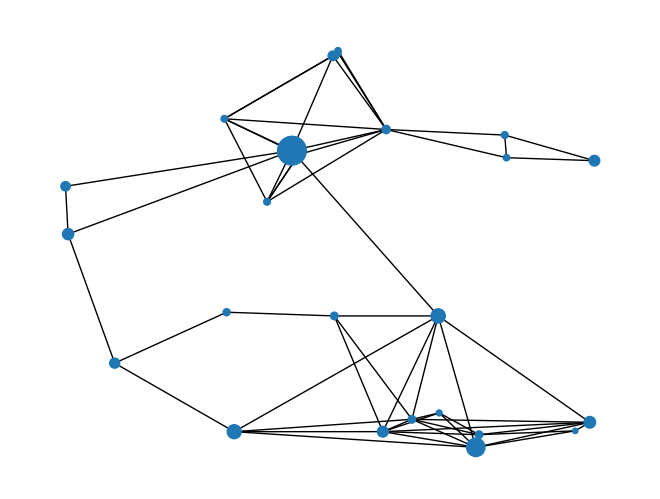

In [61]:
seuil = 0.08

G = nx.Graph()

for cluster in clusters:
    G.add_node(cluster, pos=cityCenters.get(cluster))

pos = nx.get_node_attributes(G, 'pos')  

maxPop = np.max(list(populations.values()))

distances = {}
for node1 in clusters:
    for node2 in clusters:
        if(node1 > node2):
            loc1 = np.array(cityCenters.get(node1))
            loc2 = np.array(cityCenters.get(node2))
            dist = np.linalg.norm(loc2-loc1)/1000
            distances[(node1, node2)] = dist

maxDist = np.max(list(distances.values()))

for node1, node2 in distances.keys():
    dist = distances[(node1, node2)]

    popupation_score = np.min([populations.get(node1), populations.get(node2)])*10/maxPop
    distance_score = dist/maxDist*10

    weight = (popupation_score**1)/(distance_score**2)
    if(weight>=seuil):
        G.add_edge(node1, node2, weight=weight)

node_sizes = [populations.get(node)/5000 for node in G.nodes]   
nx.draw(G, pos, node_size = node_sizes)
# plt.savefig("../../../weekly_slides/images/road_detection/edges_weight_angle_filtration.png")

In [62]:
node1 = list(cityNames.keys())[list(cityNames.values()).index('Paris')]
node2 = list(cityNames.keys())[list(cityNames.values()).index('Bordeaux')]

dist = distances[(node1, node2)]
weight = ((np.min([populations.get(node1), populations.get(node2)])/maxPop)**1.5)/(dist**1.3)

print(weight)

1.3348734427018304e-05


In [ ]:
list(cityNames.values()).index('Toulouse')

2

In [ ]:
cityBsStationCount.get(2)

109